In [97]:
import pickle
from pathlib import Path
import warnings
from collections import defaultdict

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
from dowhy import CausalModel

from structure_data import choose_columns, preprocess_data
# set random seed
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [98]:
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [99]:
ROOT = Path("./")
RAW_DATA = ROOT / "raw_data/csv/eqls_2007and2011.csv"
DICT_PATH = ROOT / "data/dictionary.json"
GRAPH_PATH = ROOT / "graphs/full_causal.gpickle"
TREATMENT = "Y11_Q57"
OUTCOME = "Y11_MWIndex"


def _prep_ordinals_inplace(df: pd.DataFrame, ord_cols, known_orders=None):
    """
    Map ordinal levels to 0..m-1 and scale to [0,1] so L1 equals Gower per-feature.
    known_orders: optional dict {col: [lowest,...,highest]} to control ordering.
    """
    for c in ord_cols:
        if known_orders and c in known_orders:
            order = {v: i for i, v in enumerate(known_orders[c])}
            df[c] = df[c].map(order).astype(float)
            m = max(order.values()) if order else 1
            df[c] = df[c] / (m if m > 0 else 1.0)
        else:
            # infer: if numeric-coded, scale min–max; else sort unique labels
            if pd.api.types.is_numeric_dtype(df[c]):
                lo, hi = df[c].min(), df[c].max()
                rng = (hi - lo) if hi > lo else 1.0
                df[c] = (df[c] - lo) / rng
            else:
                levels = sorted(df[c].dropna().unique().tolist())
                mapping = {v: i for i, v in enumerate(levels)}
                m = max(mapping.values()) if mapping else 1
                df[c] = df[c].map(mapping).astype(float) / (m if m > 0 else 1.0)

def _apply_ordinals_binning(df: pd.DataFrame, ord_cols, n_bins=4):
    for c in ord_cols:
        df[c] = pd.qcut(df[c], q=n_bins, labels=False, duplicates="drop")

def load_data() -> pd.DataFrame:
    """Load and preprocess the raw EQLS data."""
    bdvs = [
        "Y11_EmploymentStatus",
        "Y11_HHstructure",
        "Y11_HHsize",
        "Y11_Agecategory",
        "Y11_Q7",
        "Y11_Q31",
        "Y11_Country",
        "Y11_Q32",
        "Y11_HH2a",
        TREATMENT,
        OUTCOME,
    ]
    df = choose_columns()
    df = preprocess_data(
        df,
        na_threshold=0.5,
        impute_strategy="drop",
        treatment_dichotomize_value="median",
        treatment_column=TREATMENT,
        backdoor_variables=bdvs,
    )
    df.to_csv("data/eqls_processed.csv", index=False)
    return df


def get_schema() -> dict:
    categorical = ["Y11_Q32", "Y11_Q7"]
    ordinal = [
        "Y11_Agecategory",
        "Y11_Country",
        "Y11_EmploymentStatus",
        "Y11_HH2a",
        "Y11_HHsize",
        "Y11_HHstructure",
        "Y11_Q31",
    ]
    return {"cat": categorical, "ord": ordinal}


def load_graph() -> nx.DiGraph:
    """Load the causal graph describing relationships among variables."""
    with open(GRAPH_PATH, "rb") as f:
        return pickle.load(f)


def t_learner_estimate(
    df: pd.DataFrame,
    schema: dict,
    treatment_col: str,
    outcome_col: str,
) -> float:
    """
    T-learner ATE using two outcome models:
      - f1 trained on treated data
      - f0 trained on control data
    Returns mean_i [ f1(x_i) - f0(x_i) ].
    If outcome is not binary {0,1}, falls back to linear regression.

    Assumes df already has ordinal columns numerically scaled.
    """
    # Features: confounders only (no T, no Y)
    feat_cols = schema["cat"] + schema["ord"]
    X = df[feat_cols].copy()

    # Ensure categoricals are treated as such, then one-hot on FULL X (to align cols)
    for c in schema["cat"]:
        X[c] = X[c].astype("category")
    X_enc = pd.get_dummies(X, columns=schema["cat"], drop_first=True)

    T = df[treatment_col].astype(int).values
    y = df[outcome_col].values

    X1, y1 = X_enc[T == 1], y[T == 1]
    X0, y0 = X_enc[T == 0], y[T == 0]

    g1 = LinearRegression()
    g0 = LinearRegression()
    g1.fit(X1, y1)
    g0.fit(X0, y0)
    mu1 = g1.predict(X_enc)
    mu0 = g0.predict(X_enc)

    ite = mu1 - mu0
    ate = float(np.nanmean(ite))
    return ate

def load_model(df, graph, kwargs={}) -> CausalModel: 
    df2 = df.copy()
    _prep_ordinals_inplace(df2, get_schema()["ord"])
    if "ordinals_binning" in kwargs and "n" in kwargs:
        print("applying ordinals binning")
        _apply_ordinals_binning(df2, get_schema()["ord"])

    return CausalModel(
        data=df2,
        treatment=TREATMENT,
        outcome=OUTCOME,
        graph=nx.nx_pydot.to_pydot(graph).to_string(),
    )

In [ ]:
METHODS = [
        "backdoor.propensity_score_matching",
        "backdoor.propensity_score_weighting",
        "backdoor.propensity_score_stratification",
        "backdoor.linear_regression",
        "backdoor.distance_matching",
        "backdoor.T_learner",  # <- custom
    ]
DEFAULT_KWARGS = {
        "backdoor.distance_matching": dict(
            target_units="ate",
            method_params={
                'distance_metric': "minkowski",
                'p': 1,
                "num_matches_per_unit": 1,
                "exact_match_cols": get_schema()["cat"],
            },
        )
    }

def exact_match_ate(df, treatment, outcome, exact_cols, target_units="ate"):
    # keep only strata with overlap
    grp = df.groupby(exact_cols + [treatment]).size().unstack(fill_value=0)
    good = grp[(grp.get(1,0) > 0) & (grp.get(0,0) > 0)].index
    if len(good) == 0:
        raise ValueError("No overlapping strata under exact matching.")

    effects, weights = [], []
    for key in good:
        mask = (df.set_index(exact_cols).index == key) if isinstance(key, tuple) is False else \
               (df.set_index(exact_cols).index == tuple(key))
        d = df[mask]
        mu1 = d.loc[d[treatment]==1, outcome].mean()
        mu0 = d.loc[d[treatment]==0, outcome].mean()
        eff = mu1 - mu0
        if target_units == "att":
            w = (d[treatment]==1).sum()
        elif target_units == "atc":
            w = (d[treatment]==0).sum()
        else:  # "ate"
            w = len(d)
        effects.append(eff); weights.append(w)
    import numpy as np
    return float((np.array(weights)*np.array(effects)).sum()/np.array(weights).sum())

def estimate_effects(df: pd.DataFrame, graph: nx.DiGraph, model: CausalModel, methods: list = METHODS, kwargs: dict = DEFAULT_KWARGS) -> dict:

    estimand = model.identify_effect()
    results = {}
    for m in methods:
        print(f"Estimating with method: {m}")
        try:
            if m == "backdoor.T_learner":
                # Call our custom estimator
                ate = t_learner_estimate(
                    df, get_schema(), treatment_col=TREATMENT, outcome_col=OUTCOME
                )
                results[m] = ate
            elif m == "backdoor.exact_matching_manual":
                p = kwargs.get(m, {})
                ate = exact_match_ate(
                    df,
                    treatment=TREATMENT,
                    outcome=OUTCOME,
                    exact_cols=p["exact_match_cols"],
                    target_units=p.get("target_units", "ate"),
                )
                results[m] = ate
            else:
                print(kwargs.get(m, {}))
                est = model.estimate_effect(
                    estimand, method_name=m, **kwargs.get(m, {})
                )
                dm = est.estimator
                print("exact_match_cols ->", dm.exact_match_cols)  # should show your list
                results[m] = float(est.value)
        except Exception as e:
            print(f"[!] Estimation with {m} failed: {e}")
            results[m] = float("nan")
    return results

In [182]:
import numpy as np
import pandas as pd

def exact_matching_ate(
    df: pd.DataFrame,
    cat_cols,
    ord_cols,
    treat_col: str,
    outcome_col: str,
    dropna: bool = True,
    return_details: bool = False,
    # Ordinals binning (from previous version)
    ord_binning=None,
    # NEW: treat ordinals as exact or continuous
    ord_mode: str = "exact",  # "exact" | "continuous"
    # NEW: distance matching options when ord_mode="continuous"
    distance_metric: str = "euclidean",  # "euclidean"|"minkowski"|"mahalanobis"|"seuclidean"
    p: int = 2,                           # for minkowski
    standardize: bool = True,             # z-score for euclidean/minkowski
    num_matches_per_unit: int = 1,        # k-NN
    with_replacement: bool = True,        # candidate reuse
    caliper: float = None                 # max allowed distance (None = no caliper)
):
    """
    ATE via:
      - Exact matching on cat+ord (ord may be pre-binned via 'ord_binning'), OR
      - Mixed matching: exact on categorical, distance-based on ordinal ('continuous').

    When ord_mode="continuous":
      • Within each categorical stratum, match each unit to k nearest neighbors from the opposite
        treatment group using the chosen distance on 'ord_cols'. 
      • Impute counterfactuals from neighbors' outcomes; compute unit-level effects; ATE is the mean
        over all units with at least one valid neighbor.
    """
    if ord_mode not in {"exact", "continuous"}:
        raise ValueError("ord_mode must be 'exact' or 'continuous'.")

    covs = list(cat_cols) + list(ord_cols)
    use_cols = covs + [treat_col, outcome_col]
    data = df[use_cols].copy()

    # Optional binning of ordinals (for ord_mode='exact' or if you just want coarsening)
    if ord_binning is not None and len(ord_cols) > 0:
        _apply_ordinals_binning_inplace(data, ord_cols, ord_binning)

    if dropna:
        data = data.dropna(subset=use_cols)

    if data.empty:
        raise ValueError("No data left after NA handling.")
    unique_t = set(np.unique(data[treat_col]))
    if unique_t - {0, 1}:
        raise ValueError(f"'{treat_col}' must be binary (0/1).")

    # --- Path 1: Exact matching on all covariates (cat + ord) ---
    if ord_mode == "exact":
        grp = data.groupby(covs + [treat_col], dropna=False)
        stats = grp[outcome_col].agg(['mean', 'count']).reset_index()
        wide = stats.pivot_table(index=covs, columns=treat_col, values=['mean', 'count'])

        mean0 = wide['mean'].get(0)
        mean1 = wide['mean'].get(1)
        n0    = wide['count'].get(0)
        n1    = wide['count'].get(1)

        strata = pd.DataFrame(index=wide.index).assign(
            n0 = n0.fillna(0).astype(int),
            n1 = n1.fillna(0).astype(int),
            y0 = mean0,
            y1 = mean1,
        )

        strata = strata[(strata['n0'] > 0) & (strata['n1'] > 0)].copy()
        if strata.empty:
            raise ValueError("No overlapping strata found (no exact matches).")

        strata['N'] = strata['n0'] + strata['n1']
        strata['diff'] = strata['y1'] - strata['y0']

        total_matched = strata['N'].sum()
        ate = (strata['diff'] * strata['N']).sum() / total_matched

        if not return_details:
            return float(ate)
        details = {
            'matched_fraction': float(total_matched) / float(len(data)),
            'n_matched': int(total_matched),
            'n_total': int(len(data)),
            'mode': 'exact',
            'strata_summary': strata.reset_index(),
        }
        return float(ate), details

    # --- Path 2: Mixed mode — exact on categorical, distance on ordinals ---
    # Validate ordinals numeric for continuous distances
    if len(ord_cols) == 0:
        raise ValueError("ord_mode='continuous' requires non-empty ord_cols.")
    if not all(np.issubdtype(data[c].dtype, np.number) for c in ord_cols):
        raise TypeError("All ord_cols must be numeric for ord_mode='continuous'.")

    # Group by categorical exact strata; distance-match within each stratum
    if len(cat_cols) == 0:
        strata_groups = [("", data)]  # single pseudo-stratum
    else:
        strata_groups = list(data.groupby(cat_cols, dropna=False))

    # Collect unit-level effects
    unit_effects = []
    unmatched_units = 0
    total_units = len(data)

    for _, df_s in strata_groups:
        t_mask = df_s[treat_col] == 1
        c_mask = ~t_mask
        if (t_mask.sum() == 0) or (c_mask.sum() == 0):
            # no opposite group in this categorical stratum—nobody can be matched here
            unmatched_units += len(df_s)
            continue

        Xt = df_s.loc[t_mask, ord_cols].to_numpy(dtype=float, copy=False)
        Xc = df_s.loc[c_mask, ord_cols].to_numpy(dtype=float, copy=False)
        yt = df_s.loc[t_mask, outcome_col].to_numpy(dtype=float, copy=False)
        yc = df_s.loc[c_mask, outcome_col].to_numpy(dtype=float, copy=False)

        # Compute distance matrices between treated and controls
        Dt, Dc = _pairwise_distances_two_way(
            Xt, Xc,
            metric=distance_metric,
            p=p,
            standardize=standardize
        )
        # Optional caliper filtering
        if caliper is not None:
            Dt = Dt.copy()
            Dc = Dc.copy()
            Dt[Dt > caliper] = np.inf
            Dc[Dc > caliper] = np.inf

        # Match treated -> controls
        cf0_treated, matched_t = _impute_counterfactuals_from_neighbors(
            opposite_outcomes=yc,
            D=Dt,
            k=num_matches_per_unit,
            with_replacement=with_replacement
        )
        # Match controls -> treated
        cf1_controls, matched_c = _impute_counterfactuals_from_neighbors(
            opposite_outcomes=yt,
            D=Dc,
            k=num_matches_per_unit,
            with_replacement=with_replacement
        )

        # Build unit-level effects
        # Treated units: tau_i = y_i - E[y0 | matches]
        if matched_t.any():
            unit_effects.append(yt[matched_t] - cf0_treated[matched_t])
        # Control units: tau_j = E[y1 | matches] - y_j
        if matched_c.any():
            unit_effects.append(cf1_controls[matched_c] - yc[matched_c])

        unmatched_units += (~matched_t).sum() + (~matched_c).sum()

    if len(unit_effects) == 0:
        raise ValueError("No units could be matched under the chosen settings (check caliper/metric).")

    unit_effects = np.concatenate(unit_effects, axis=0)
    ate = float(np.mean(unit_effects))

    if not return_details:
        return ate

    details = {
        'matched_fraction': 1.0 - (unmatched_units / (2 * total_units)),  # approx: both directions counted
        'n_total': int(total_units),
        'n_effects': int(unit_effects.size),
        'mode': 'continuous',
        'distance_metric': distance_metric,
        'standardize': standardize,
        'num_matches_per_unit': num_matches_per_unit,
        'with_replacement': with_replacement,
        'caliper': caliper,
    }
    return ate, details


# ---------- Helpers ----------

def _apply_ordinals_binning_inplace(df: pd.DataFrame, ord_cols, ord_binning):
    if isinstance(ord_binning, int):
        cfg = {c: {"method": "quantile", "n_bins": ord_binning} for c in ord_cols}
    elif isinstance(ord_binning, dict):
        cfg = ord_binning
    else:
        raise ValueError("ord_binning must be None, int, or dict.")

    for c in ord_cols:
        if c not in df.columns:
            raise KeyError(f"Ordinal column '{c}' not in DataFrame.")
        spec = cfg.get(c, None)
        if spec is None:
            continue
        method = spec.get("method", "quantile")
        if method == "quantile":
            n_bins = int(spec.get("n_bins", 4))
            df[c] = pd.qcut(df[c], q=n_bins, labels=False, duplicates="drop")
        elif method == "uniform":
            n_bins = int(spec.get("n_bins", 4))
            df[c] = pd.cut(df[c], bins=n_bins, labels=False, include_lowest=True)
        elif method == "custom":
            bins = spec.get("bins", None)
            if not bins or len(bins) < 2:
                raise ValueError(f"Custom binning for '{c}' requires a 'bins' list with >=2 edges.")
            df[c] = pd.cut(df[c], bins=bins, labels=False, include_lowest=True)
        else:
            raise ValueError(f"Unknown binning method '{method}' for column '{c}'.")
        # ensure integer-ish for exact mode friendliness
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = df[c].astype('Int64')
        else:
            df[c] = df[c].astype('Int64')


def _zscore(X):
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0, ddof=0)
    sd[sd == 0] = 1.0
    return (X - mu) / sd, mu, sd


def _pairwise_distances_two_way(Xt, Xc, metric="euclidean", p=2, standardize=True):
    """
    Returns (Dt, Dc):
      Dt: distances from each treated (rows) to each control (cols)
      Dc: distances from each control (rows) to each treated (cols)
    """
    Xtp = Xt
    Xcp = Xc

    if metric in {"euclidean", "minkowski"} and standardize:
        Xtp, mu, sd = _zscore(Xt)
        Xcp = (Xc - mu) / sd

    if metric == "euclidean" or (metric == "minkowski" and p == 2):
        # squared distances then sqrt for stability
        Dt = np.sqrt(np.maximum(0.0, _cdist_sq(Xtp, Xcp)))
        Dc = Dt.T.copy()
        return Dt, Dc

    if metric == "minkowski":
        Dt = _cdist_minkowski(Xtp, Xcp, p=p)
        Dc = Dt.T.copy()
        return Dt, Dc

    if metric == "seuclidean":
        # standardized Euclidean using pooled variances
        _, mu, sd = _zscore(np.vstack([Xt, Xc]))
        Xtp = (Xt - mu) / sd
        Xcp = (Xc - mu) / sd
        Dt = np.sqrt(np.maximum(0.0, _cdist_sq(Xtp, Xcp)))
        Dc = Dt.T.copy()
        return Dt, Dc

    if metric == "mahalanobis":
        # pooled covariance inverse
        X = np.vstack([Xt, Xc])
        Xc_mu = np.mean(X, axis=0)
        Xc_centered = X - Xc_mu
        S = np.cov(Xc_centered, rowvar=False)
        # regularize if singular
        eps = 1e-8
        S.flat[:: S.shape[0] + 1] += eps
        VI = np.linalg.pinv(S)
        Dt = _cdist_mahalanobis(Xt, Xc, VI)
        Dc = Dt.T.copy()
        return Dt, Dc

    raise ValueError(f"Unknown distance_metric: {metric}")


def _cdist_sq(A, B):
    # ||a - b||^2 = ||a||^2 + ||b||^2 - 2 a·b
    a2 = np.sum(A * A, axis=1, keepdims=True)
    b2 = np.sum(B * B, axis=1, keepdims=True).T
    return a2 + b2 - 2.0 * (A @ B.T)


def _cdist_minkowski(A, B, p=2):
    # Compute pairwise Minkowski distances
    # shape: (len(A), len(B))
    # Uses broadcasting; may be memory heavy if very large. Works fine for typical matching sizes.
    diff = A[:, None, :] - B[None, :, :]
    return np.power(np.sum(np.power(np.abs(diff), p), axis=2), 1.0 / p)


def _cdist_mahalanobis(A, B, VI):
    # d(a,b) = sqrt((a-b)ᵀ VI (a-b))
    diff = A[:, None, :] - B[None, :, :]
    # (N_a, N_b, d) x (d,d) -> (N_a, N_b, d)
    tmp = diff @ VI
    d2 = np.einsum('ijk,ijk->ij', tmp, diff)
    d2 = np.clip(d2, a_min=0.0, a_max=None)
    return np.sqrt(d2)


def _impute_counterfactuals_from_neighbors(opposite_outcomes, D, k=1, with_replacement=True):
    """
    Given distances D from focal units (rows) to candidate neighbors (cols),
    returns:
      cf (np.ndarray): imputed counterfactual outcomes per focal unit (mean over k nearest).
      matched_mask (np.ndarray[bool]): True where we found at least 1 finite-distance neighbor.

    If with_replacement=False, we greedily reserve neighbors (stable but not globally optimal).
    """
    n_focal, n_cand = D.shape
    cf = np.zeros(n_focal, dtype=float)
    matched = np.zeros(n_focal, dtype=bool)

    if n_cand == 0:
        return cf, matched

    if with_replacement:
        # For each focal, take k smallest finite distances
        order = np.argsort(D, axis=1)
        for i in range(n_focal):
            # valid neighbors (finite distances)
            nn = order[i]
            nn = nn[np.isfinite(D[i, nn])]
            if nn.size == 0:
                continue
            use = nn[: min(k, nn.size)]
            cf[i] = float(np.mean(opposite_outcomes[use]))
            matched[i] = True
        return cf, matched

    # Without replacement: greedy selection to avoid reusing the same neighbors too much
    taken = np.full(n_cand, fill_value=0, dtype=int)
    max_use = 1  # each candidate can be used at most once per greedy pass

    # Process focal units in order of their nearest available distance
    focal_order = np.argsort(np.nanmin(D, axis=1))
    for i in focal_order:
        # sort candidate neighbors for this focal
        idxs = np.argsort(D[i, :])
        idxs = [j for j in idxs if np.isfinite(D[i, j])]
        chosen = []
        for j in idxs:
            if taken[j] < max_use:
                taken[j] += 1
                chosen.append(j)
                if len(chosen) == k:
                    break
        if len(chosen) > 0:
            cf[i] = float(np.mean(opposite_outcomes[chosen]))
            matched[i] = True

    return cf, matched

In [183]:
df = load_data()
graph = load_graph()

In [184]:
backdoor_variables = ['Y11_EmploymentStatus',
 'Y11_HHstructure',
 'Y11_HHsize',
 'Y11_Agecategory',
 'Y11_Q7',
 'Y11_Q31',
 'Y11_Country',
 'Y11_Q32',
 'Y11_HH2a',
]
treatment_and_outcome = [TREATMENT, OUTCOME]

In [185]:
ate = exact_matching_ate(df[backdoor_variables +treatment_and_outcome], cat_cols=get_schema()["cat"], ord_cols=get_schema()["ord"], treat_col=TREATMENT, outcome_col=OUTCOME, ord_binning=None, return_details=True)
print(ate)

(5.677429859538927, {'matched_fraction': 0.46280452436194897, 'n_matched': 19149, 'n_total': 41376, 'mode': 'exact', 'strata_summary':       Y11_Q32  Y11_Q7  Y11_Agecategory  Y11_Country  Y11_EmploymentStatus  \
0         0.0     0.0                1            1                     6   
1         0.0     0.0                1            1                     6   
2         0.0     0.0                1            1                     6   
3         0.0     0.0                1            1                     6   
4         0.0     0.0                1            2                     2   
...       ...     ...              ...          ...                   ...   
3161      5.0     0.0                5           34                     4   
3162      5.0     0.0                5           34                     4   
3163      5.0    38.0                4           11                     1   
3164      5.0    40.0                3            4                     1   
3165      5.0    6

**Robustness Checks**

Matching- more methods for ordinal (which we treat as continual), ordinal exact matching (gower), ordinal binned exact matching (cem).

In [ ]:
import itertools

# Define sweep values
distance_metrics = ["euclidean", "minkowski", "mahalanobis", "seuclidean"]
p_values = [1, 2]
num_matches_values = [1, 2, 3]
ord_modes = ["exact", "continuous"]
binning_values = [3, 4, 5]

results = []

for ord_mode in ord_modes:
    for binning in binning_values:
        for metric in distance_metrics:
            for p in p_values:
                for k in num_matches_values:
                    try:
                        ate, details = exact_matching_ate(
                            df,
                            cat_cols= get_schema()["cat"],
                            ord_cols= get_schema()["ord"],
                            treat_col=TREATMENT,
                            outcome_col=OUTCOME,
                            ord_mode=ord_mode,
                            ord_binning=binning if ord_mode == "exact" else None,
                            distance_metric=metric,
                            p=p,
                            num_matches_per_unit=k,
                            return_details=True
                        )
                        print(
                            f"[SUCCESS] ord_mode={ord_mode}, "
                            f"binning={binning if ord_mode=='exact' else None}, "
                            f"metric={metric}, p={p}, k={k} "
                            f"=> ATE={ate:.4f}, matched_fraction={details['matched_fraction']:.3f}"
                        )
                    except Exception as e:
                        print(
                            f"[ERROR] ord_mode={ord_mode}, "
                            f"binning={binning if ord_mode=='exact' else None}, "
                            f"metric={metric}, p={p}, k={k} "
                            f"=> {str(e)}"
                        )

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.head())

[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=1, k=1 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object')] are in the [columns]"
[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=1, k=2 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object')] are in the [columns]"
[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=1, k=3 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object')] are in the [columns]"
[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=2, k=1 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object')] are in the [columns]"
[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=2, k=2 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object')] are in the [columns]"
[ERROR] ord_mode=exact, binning=3, metric=euclidean, p=2, k=3 => "None of [Index(['sex', 'hospital', 'age', 'asa', 'treated', 'y'], dtype='object

In [151]:
possible_kwargs = [
    { # euclidean distance
        "name": "euclidean distance",
        "backdoor.distance_matching": dict(
            target_units="ate",
            method_params={
                "distance_metric": "minkowski",
                "p": 2,
                "num_matches_per_unit": 1,
                "fit_params":
                    {"exact_match_cols": get_schema()["cat"]}            },
        )
    },
    { # mahalanobis distance
        "name": "mahalanobis distance",
        "backdoor.distance_matching": dict(
            target_units="ate",
            method_params={
                "distance_metric": "mahalanobis",
                "num_matches_per_unit": 1,
                "fit_params":
                    {"exact_match_cols": get_schema()["cat"]},
             }
        )
    },
    { # default distance with ordinal variables treated as categorical (exact matching)
        "name": "exact matching",
        "backdoor.distance_matching": dict(
            target_units="ate",
            method_params={
                "distance_metric": "minkowski",
                "p": 1,
                "num_matches_per_unit": 1,
                "fit_params":
                    {"exact_match_cols": get_schema()["cat"]}
            },
        )
    },
    { # default distance with ordinal variables treated as categorical (exact matching), with binning (CEM)
        "name": "exact matching with binning",  
        "backdoor.distance_matching": dict(
            target_units="ate",
            method_params={
                'distance_metric': "hamming",
                "num_matches_per_unit": 3,
                "fit_params":
                    {"exact_match_cols": get_schema()["cat"] + get_schema()["ord"]}
            },

        ),
        "ordinals_binning": True
    },  
    ]

In [152]:
# Run matching with different sets of parameters for robustness
results_per_experiment = {}
model = None
for kwargs in possible_kwargs:
    print(f"Running experiment with name: {kwargs['name']}")
    del model
    # Run the experiment with the current set of kwargs
    model = load_model(df, graph, kwargs)
    results_per_experiment[kwargs["name"]] = estimate_effects(df, graph, model, methods=["backdoor.distance_matching"], kwargs=kwargs)
    print(results_per_experiment[kwargs["name"]])


results_per_method = defaultdict(list)
for name, result in results_per_experiment.items():
    for method, effect in result.items():
        results_per_method[method].append(effect)




Running experiment with name: euclidean distance
Estimating with method: backdoor.distance_matching
{'target_units': 'ate', 'method_params': {'distance_metric': 'minkowski', 'p': 2, 'num_matches_per_unit': 1, 'fit_params': {'exact_match_cols': ['Y11_Q32', 'Y11_Q7']}}}
[!] Estimation with backdoor.distance_matching failed: single positional indexer is out-of-bounds
{'backdoor.distance_matching': nan}
Running experiment with name: mahalanobis distance
Estimating with method: backdoor.distance_matching
{'target_units': 'ate', 'method_params': {'distance_metric': 'mahalanobis', 'num_matches_per_unit': 1, 'fit_params': {'exact_match_cols': ['Y11_Q32', 'Y11_Q7']}}}
[!] Estimation with backdoor.distance_matching failed: Must provide either V or VI for Mahalanobis distance
{'backdoor.distance_matching': nan}
Running experiment with name: exact matching
Estimating with method: backdoor.distance_matching
{'target_units': 'ate', 'method_params': {'distance_metric': 'minkowski', 'p': 1, 'num_match

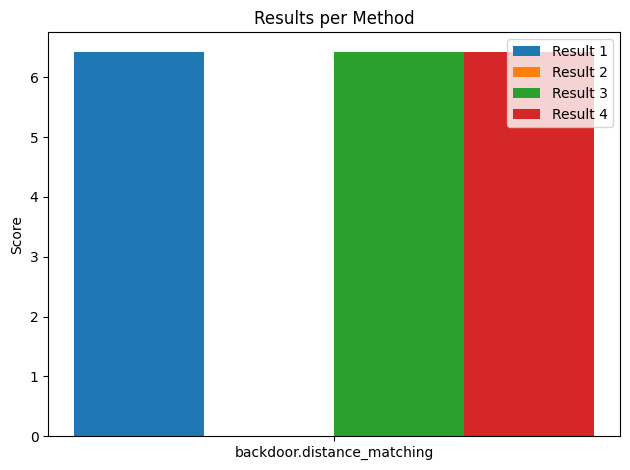

In [64]:
from matplotlib import pyplot as plt
# Methods and number of values
methods = list(results_per_method.keys())
n_values = max(len(v) for v in results_per_method.values())

# x locations for groups
x = np.arange(len(methods))
bar_width = 0.15  # width of each bar

# Plot each result index separately
for i in range(n_values):
    vals = [results_per_method[m][i] if i < len(results_per_method[m]) else np.nan
            for m in methods]
    plt.bar(x + i * bar_width, vals, width=bar_width, label=f"Result {i+1}")

# Formatting
plt.xticks(x + bar_width * (n_values-1)/2, methods)
plt.ylabel("Score")
plt.title("Results per Method")
plt.legend()
plt.tight_layout()
plt.show()

Subset Analysis- Divide the data per country

In [56]:
dfs_per_countries = defaultdict(list)
results_per_country = defaultdict(dict)
for country in df['Y11_Country'].unique():
    dfs_per_countries[country] = df[df['Y11_Country'] == country]
for country, df_country in dfs_per_countries.items():
    model = load_model(df_country, graph)
    results_per_country[int(country)] = estimate_effects(df_country, graph, model)

for country, results in results_per_country.items():
    print(f"Results for {country}:")
    for method, effect in results.items():
        print(f"  {method}: {effect}")

# save to json
import json
with open("results_per_country.json", "w") as f:
    json.dump(results_per_country, f)


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Results for 15:
  backdoor.propensity_score_matching: 6.26070935052971
  backdoor.propensity_score_weighting: 5.586950015515313
  backdoor.propensity_score_stratification: 5.348653125801907
  backdoor.linear_regression: 5.362736044608219
  backdoor.distance_matching: 7.266697374481804
  backdoor.T_learner: 5.71987064370324
Results for 6:
  backdoor.propensity_score_matching: 6.053231939163498
  backdoor.propensity_score_weighting: 5.100157652826638
  backdoor.propensity_score_stratification: 4.719241435246797
  backdoor.linear_regression: 4.832114862532833
  backdoor.distance_matching: 4.493605254061528
  backdoor.T_learner: 4.794948045729591
Results for 12:
  backdoor.propensity_score_matching: 2.2216216216216216
  backdoor.propensity_score_weighting: 2.5786529387371004
  backdoor.propensity_score_stratification: 0.9425921879302313
  backdoor.linear_regression: 2.189808467720134
  backdoor.distance_matching: 1.072072072072072
  backdoor.T_learner: 2.468776576078513
Results for 27:
  b

In [41]:
results_per_method = defaultdict(list)
for country, results in results_per_country.items():
    for method, effect in results.items():
        results_per_method[method].append((int(country), effect))



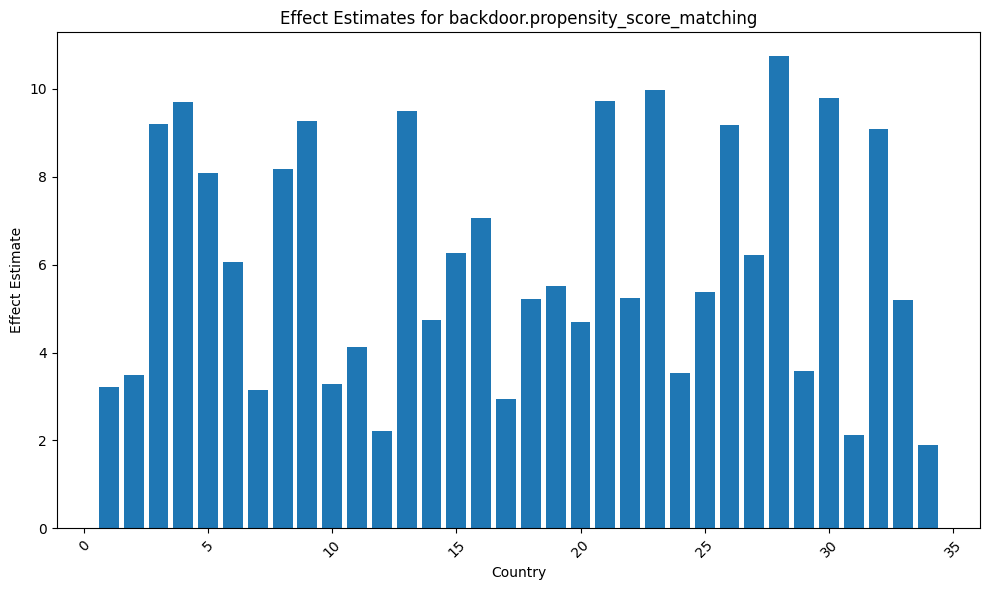

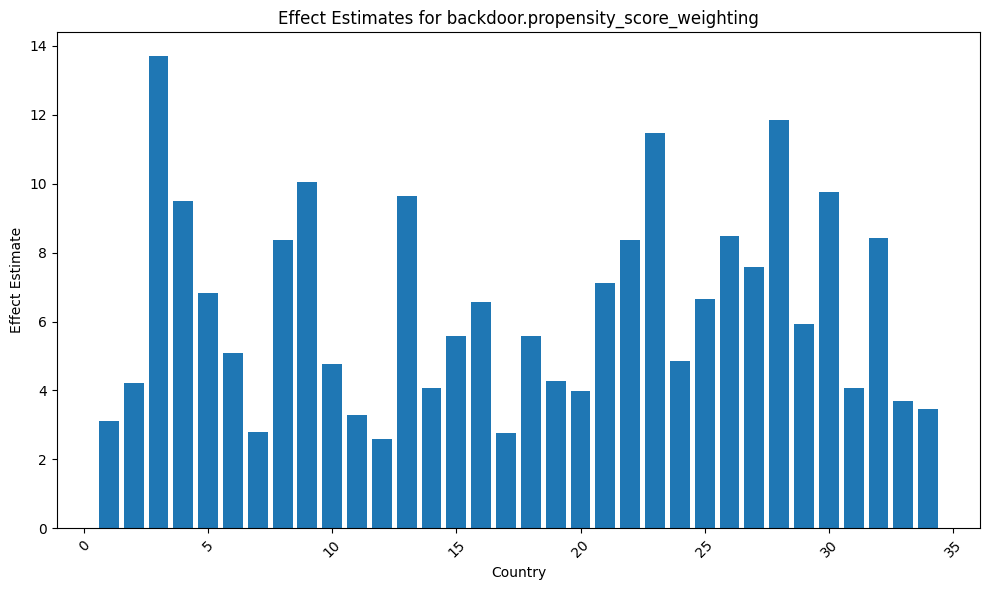

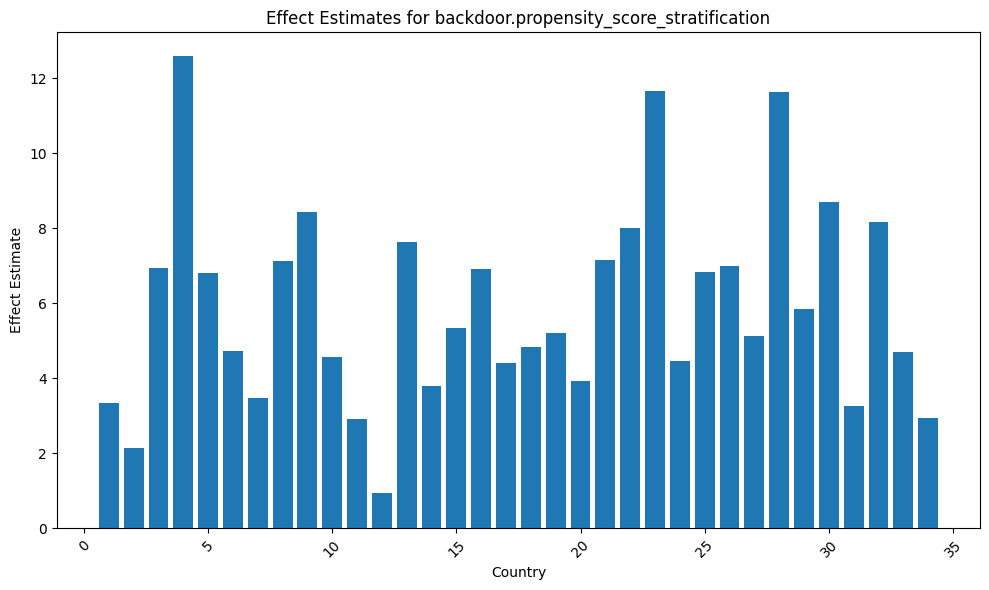

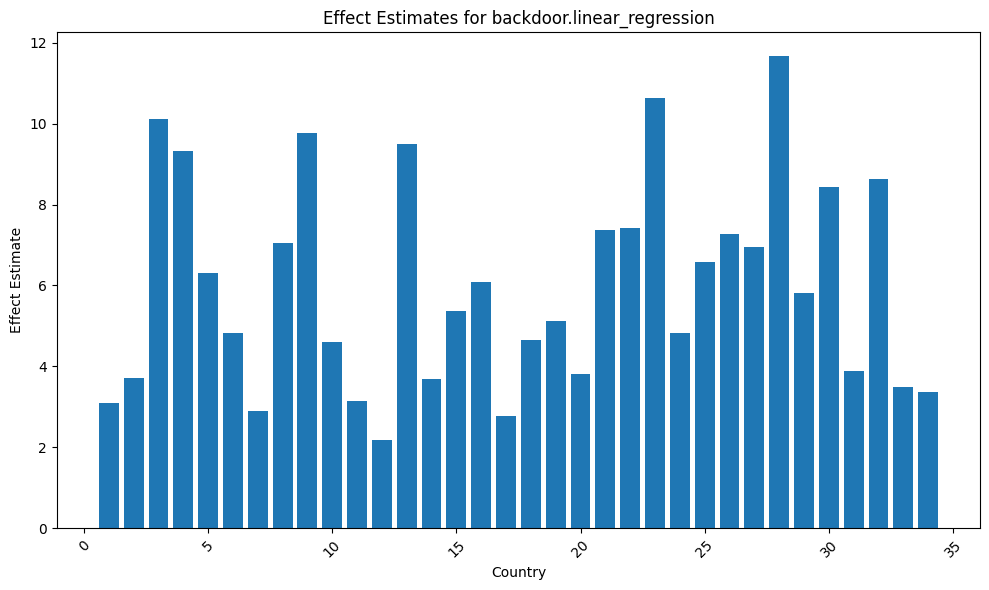

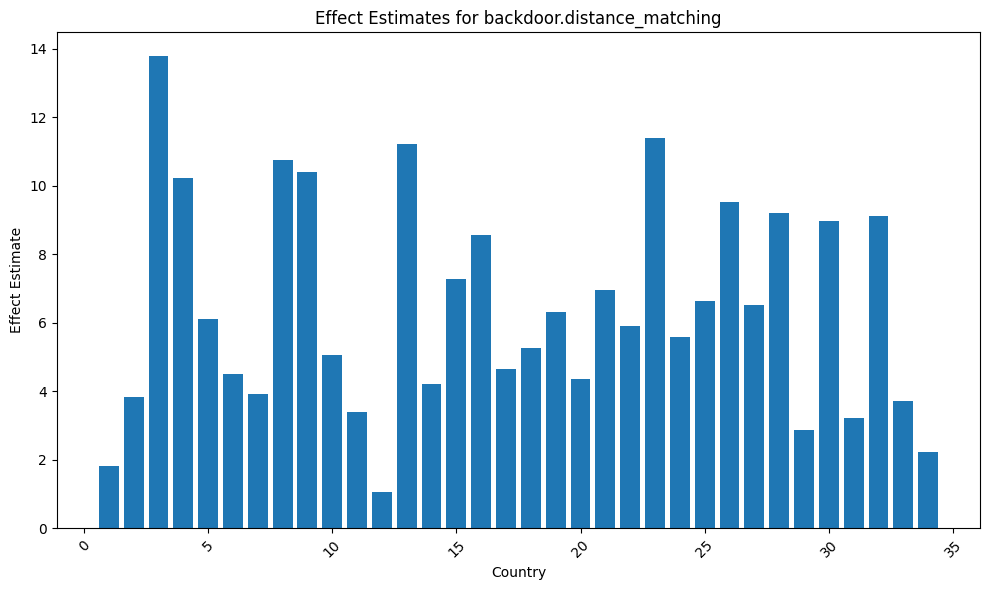

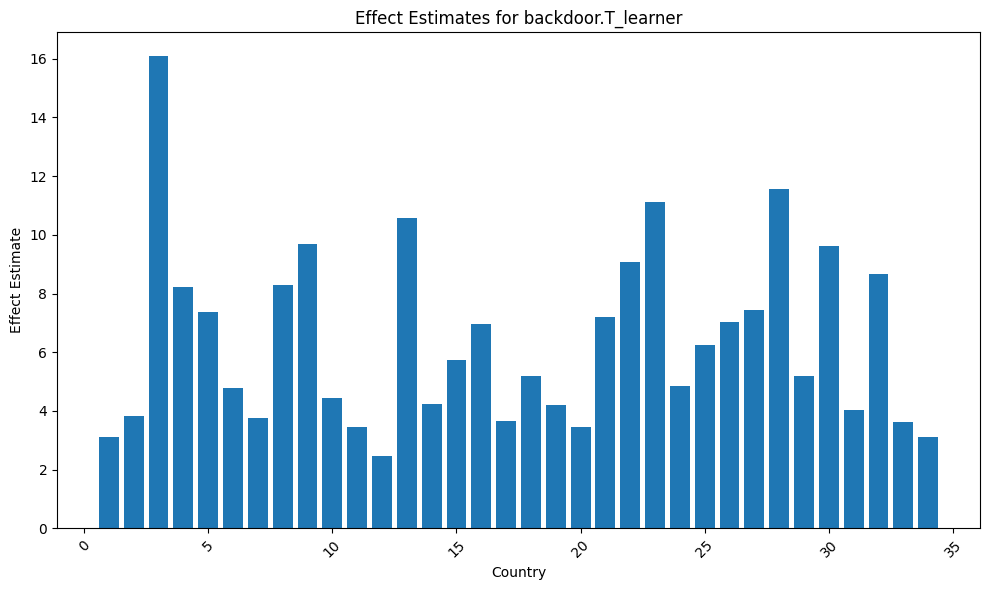

In [42]:
# generate summary plots
import matplotlib.pyplot as plt

for method, results in results_per_method.items():
    countries, effects = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.bar(countries, effects)
    plt.title(f"Effect Estimates for {method}")
    plt.xlabel("Country")
    plt.ylabel("Effect Estimate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# plot per-country effects, calculate mean std 
import matplotlib.pyplot as plt

for country, results in results_per_country.items():
    methods, effects = zip(*results.items())
    plt.figure(figsize=(10, 6))
    plt.bar(methods, effects)
    plt.title(f"Effect Estimates for {country}")
    plt.xlabel("Method")
    plt.ylabel("Effect Estimate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


propensity score- different levels of trimming

refutation test- random variables addition 

data subsampling

In [ ]:
# Use different percentage 